# Imports

In [2]:
!pip install langdetect
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, udf, lower, trim, regexp_replace, from_unixtime, length,
    count, avg, when, floor
)
from pyspark.sql.types import StringType, IntegerType, ArrayType
from langdetect import detect
import nltk
from nltk.corpus import stopwords
import string
from pyspark import StorageLevel
from pyspark.sql import functions as F
from pyspark.sql import Window
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pyspark as ps
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from nltk.stem import WordNetLemmatizer
#--------------------------------Model Imports
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from nltk.stem import WordNetLemmatizer
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

nltk.download('wordnet')

Matplotlib created a temporary cache directory at /scratch/jklayman/job_39987060/matplotlib-aat54brl because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
[nltk_data] Downloading package wordnet to /home/jklayman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Spark builder
sc = SparkSession.builder \
    .appName("FastGroupByCount") \
    .master("local[110]") \
    .config("spark.driver.memory", "220g") \
    .config("spark.sql.shuffle.partitions", "220") \
    .config("spark.default.parallelism", "220") \
    .getOrCreate()

In [5]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()

In [6]:
from pyspark import SparkContext
spark = SparkContext.getOrCreate()
print("Spark master:", spark.master)

Spark master: local[110]


# Milestone 2: Data Exploration and Preprocessing

## Initial Cleaning

In [7]:
# Depreciated read in of csv
df = sc.read.csv(
     "/expanse/lustre/scratch/troman1/temp_project/all_reviews.csv",
     header=True,
     inferSchema=False,
     multiLine=True,
     escape="\""
)

# Read in parquet file
#path = "/expanse/lustre/scratch/troman1/temp_project/parquet_output"

#df = sc.read.parquet(path)

In [8]:
# Dropping unnessecary columns as they're noisy to the data
drop_col = [
     'recommendationid', 
     'appid', 
     'author_steamid', 
     'author_playtime_last_two_weeks', 
     'author_last_played', 
     'timestamp_created', 
     'timestamp_updated', 
     'votes_funny', 
     'weighted_vote_score', 
     'comment_count', 
     'steam_purchase', 
     'hidden_in_steam_china', 
     'steam_china_location',
]
df = df.drop(*[c for c in drop_col if c in df.columns])

In [9]:
# Drop null values
df = df.dropna()

In [10]:
# Filter out emoji/ASCII-only lines in review
df = df.filter(~col("review").rlike("^[\p{Punct}\s\p{So}]+$"))

In [11]:
df = df.filter((col('language').isin(["english"])) & (length(col('review')) > 20))

In [12]:
# Lowercase all text in review
df = df.withColumn("review", lower(trim(col("review"))))

In [13]:
# Converted selected columns to optimized integer types
df = df.withColumn("author_num_games_owned", col("author_num_games_owned").cast(IntegerType())) \
     .withColumn("author_num_reviews", col("author_num_reviews").cast(IntegerType())) \
     .withColumn("author_playtime_forever", col("author_playtime_forever").cast(IntegerType())) \
     .withColumn("author_playtime_at_review", col("author_playtime_at_review").cast(IntegerType())) \
     .withColumn("votes_up", col("votes_up").cast(IntegerType())) \
     .withColumn("voted_up", col("voted_up").cast("boolean")) \
     .withColumn("received_for_free", col("received_for_free").cast("boolean")) \
     .withColumn("written_during_early_access", col("written_during_early_access").cast("boolean"))

# Verify the schema change
df.printSchema()

root
 |-- game: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- voted_up: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)



In [14]:
# Converted minutes to hours and minutes
df_with_time_change = df \
     .withColumn("at_review_hours", floor(col("author_playtime_at_review") / 60)) \
     .withColumn("forever_hours", floor(col("author_playtime_forever") / 60))

In [15]:
# Drop rows where playtime at review is more than playtime forever
df_fully_cleaned = df_with_time_change.filter(col("author_playtime_at_review") <= col("author_playtime_forever"))

In [16]:
df_fully_cleaned = df_with_time_change

In [17]:
# df_fully_cleaned.unpersist()

In [ ]:
# Wrote fully cleaned df to file.
df_fully_cleaned.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/parquet_fully_cleaned")

In [ ]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_fully_cleaned"

df_fully_cleaned = sc.read.parquet(path)

In [19]:
df_fully_cleaned.dtypes

[('game', 'string'),
 ('author_num_games_owned', 'int'),
 ('author_num_reviews', 'int'),
 ('author_playtime_forever', 'int'),
 ('author_playtime_at_review', 'int'),
 ('language', 'string'),
 ('review', 'string'),
 ('voted_up', 'boolean'),
 ('votes_up', 'int'),
 ('received_for_free', 'boolean'),
 ('written_during_early_access', 'boolean'),
 ('at_review_hours', 'bigint'),
 ('forever_hours', 'bigint')]

In [20]:
df_fully_cleaned.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[game: string, author_num_games_owned: int, author_num_reviews: int, author_playtime_forever: int, author_playtime_at_review: int, language: string, review: string, voted_up: boolean, votes_up: int, received_for_free: boolean, written_during_early_access: boolean, at_review_hours: bigint, forever_hours: bigint]

## Basic Statistics

In [ ]:
# Looking at top 10 number of reviews for games in descending order
df_fully_cleaned.groupBy('game').count().orderBy("count", ascending = False).show(10)

In [ ]:
# Number of games reviewed
num_games_reviewed = df_fully_cleaned.select("game").distinct().count()

print(f"Number of games reviewed: {num_games_reviewed}")

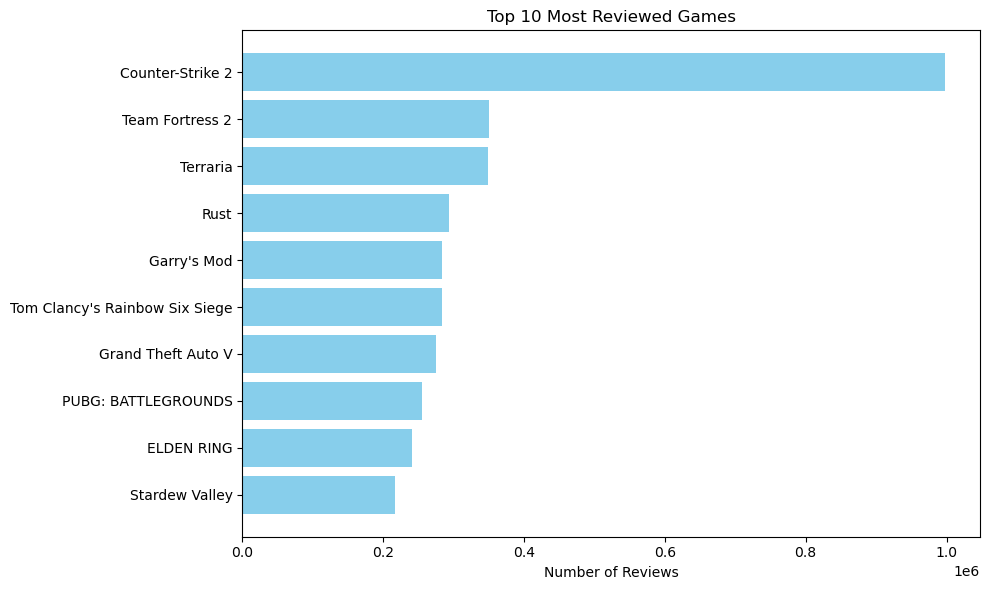

In [21]:
# Number of Reviews per Game
top_games = (
    df_fully_cleaned.groupBy("game")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(10, 6))
plt.barh(top_games["game"], top_games["count"], color="skyblue")
plt.xlabel("Number of Reviews")
plt.title("Top 10 Most Reviewed Games")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
# Average review length
avg_review_length = df_fully_cleaned.withColumn("review_length", length(col("review"))) \
                                  .agg(avg("review_length").alias("avg_length")) \
                                  .orderBy(col("avg_length").desc())

In [23]:
avg_review_length.show()

+-----------------+
|       avg_length|
+-----------------+
|321.2376410656795|
+-----------------+



In [24]:
review_length = df_fully_cleaned.select("review", length(col("review")).alias("review_length")).orderBy("review_length", ascending=False)
review_length.show()

+--------------------+-------------+
|              review|review_length|
+--------------------+-------------+
|vk.com/bagosi vk....|      9638999|
|vk.com/bagosi vk....|      9638999|
|ользователь посчи...|      4539599|
|ৣৣৣৣৣৣৣৣৣৣৣৣৣৣৣৣৣ...|       419580|
|vk.com/bagosi vk....|       262144|
|[list][list][list...|       150000|
|[list][list][list...|       150000|
|[list][list][list...|       150000|
|[list][list][list...|       150000|
|[list][list][list...|       150000|
|[list][list][list...|       150000|
|[list][list][list...|       120000|
|ːgreendb_alphaːːg...|         9229|
|oyuna sürekli̇ dr...|         8880|
|the eldar scrolls...|         8002|
|hexen 2 came out ...|         8000|
|im inside you im ...|         8000|
|look, stronghold ...|         8000|
|my entire review ...|         8000|
|i really want to ...|         8000|
+--------------------+-------------+
only showing top 20 rows



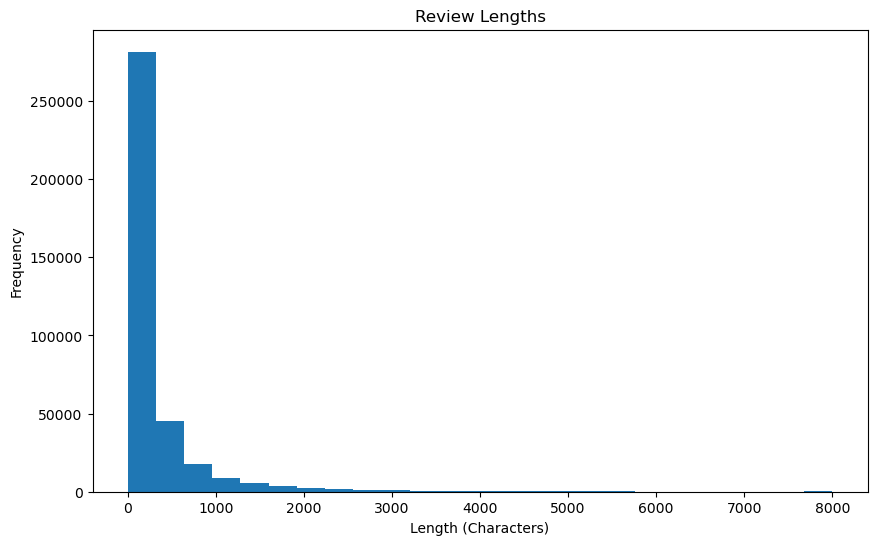

In [25]:
pd_review_length = review_length.sample(0.01, seed=42).toPandas()

plt.figure(figsize=(10, 6))
plt.title("Review Lengths")
plt.xlabel("Length (Characters)")
plt.ylabel("Frequency")
plt.hist(pd_review_length["review_length"], bins=25)
plt.show()

In [26]:
# Average number of games owned
avg_games_owned = df_fully_cleaned.select(avg("author_num_games_owned").alias("avg_games_owned"))

In [27]:
avg_games_owned.show()

+-----------------+
|  avg_games_owned|
+-----------------+
|171.7061687121295|
+-----------------+



In [28]:
num_games_owned = df_fully_cleaned.orderBy("author_num_games_owned", ascending=False)


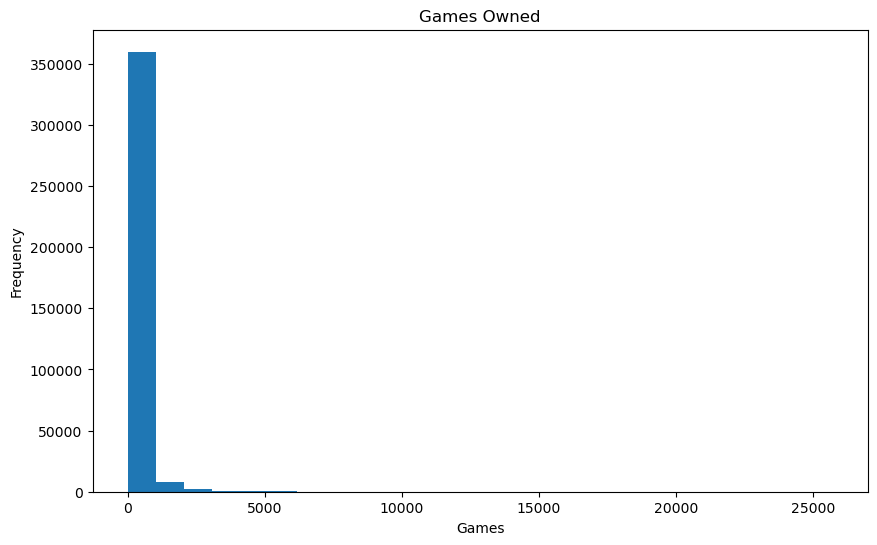

In [29]:
pd_num_games_owned = num_games_owned.sample(0.01, seed=42).toPandas()

plt.figure(figsize=(10, 6))
plt.title("Games Owned")
plt.xlabel("Games")
plt.ylabel("Frequency")
plt.hist(pd_num_games_owned["author_num_games_owned"], bins=25)
plt.show()

## Correlation Exploration

In [33]:
# Playtime at Review vs Author's Vote
playtime_at_review_vs_voted_up = df_fully_cleaned.select("game", "at_review_hours", "voted_up") \
    .filter("at_review_hours IS NOT NULL") \
    .orderBy("at_review_hours", ascending=False)

playtime_at_review_vs_voted_up.show(10)

+--------------------+---------------+--------+
|                game|at_review_hours|voted_up|
+--------------------+---------------+--------+
|     Team Fortress 2|          79609|    true|
|     Team Fortress 2|          66027|    true|
|    Counter-Strike 2|          64963|    true|
|Half-Life Deathma...|          61516|    true|
|    Counter-Strike 2|          60231|    true|
|Sid Meier's Civil...|          59038|    true|
|       Day of Defeat|          59005|   false|
|         Garry's Mod|          58742|    true|
|Sid Meier's Civil...|          57197|    true|
|Sid Meier's Civil...|          53351|    true|
+--------------------+---------------+--------+
only showing top 10 rows



In [34]:
# Do we need this?? Not in readme
# Playtime at review vs votes_up (users voting on a review)
playtime_at_review_vs_votes_up = df_fully_cleaned.select("at_review_hours", "votes_up") \
    .filter("at_review_hours IS NOT NULL") \
    .orderBy("votes_up", ascending=False)

playtime_at_review_vs_votes_up.show(10)

+---------------+--------+
|at_review_hours|votes_up|
+---------------+--------+
|              0|   62199|
|             32|   36234|
|            125|   29629|
|            114|   28252|
|              0|   21141|
|             15|   20506|
|            191|   20453|
|              3|   20075|
|           1425|   19749|
|           2192|   18960|
+---------------+--------+
only showing top 10 rows



Sample size: 371,609 rows
Estimated memory: 4.25 MB


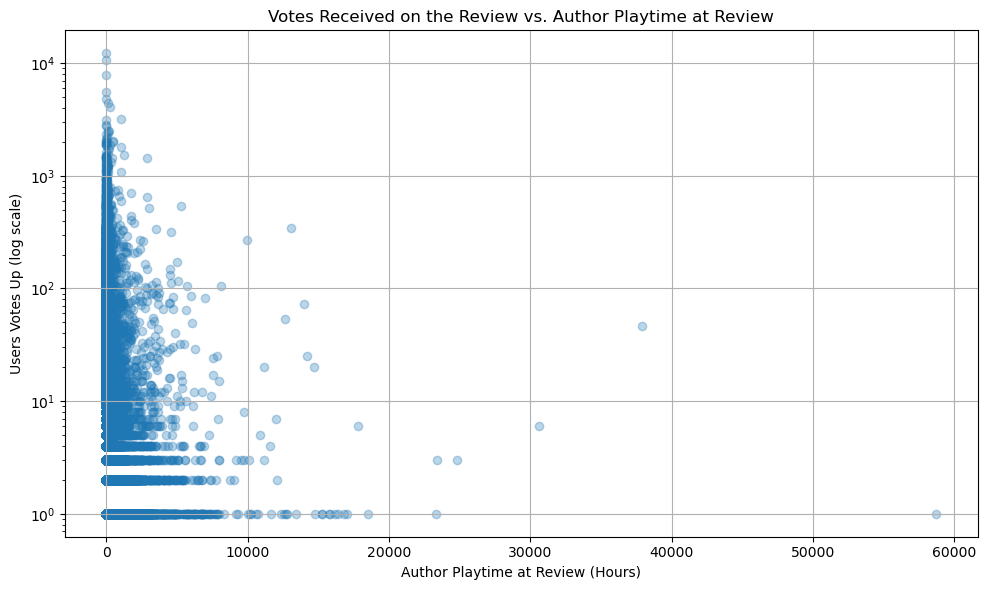

In [35]:
pdf = df_fully_cleaned \
    .select("at_review_hours", "votes_up") \
    .filter("at_review_hours IS NOT NULL") \
    .sample(fraction=0.01) \
    .toPandas()

print(f"Sample size: {len(pdf):,} rows")
print(f"Estimated memory: {pdf.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")


plt.figure(figsize=(10, 6))
plt.scatter(pdf["at_review_hours"], pdf["votes_up"], alpha=0.3)
plt.yscale("log")
plt.xlabel("Author Playtime at Review (Hours)")
plt.ylabel("Users Votes Up (log scale)")
plt.title("Votes Received on the Review vs. Author Playtime at Review")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Playtime at Review vs Author's Vote
playtime_difference_vs_voted_up = df_fully_cleaned.withColumn(
    "playtime_difference", col("forever_hours") - col("at_review_hours")) \
    .select("game", "playtime_difference", "voted_up") 

In [37]:
playtime_difference_vs_voted_up = playtime_difference_vs_voted_up.filter(col("playtime_difference") >= 0)

In [38]:
playtime_difference_vs_voted_up.orderBy("playtime_difference", ascending=False).show(3)

+-------------------+-------------------+--------+
|               game|playtime_difference|voted_up|
+-------------------+-------------------+--------+
|        Garry's Mod|              87262|    true|
|    Team Fortress 2|              81212|    true|
|Marvel Puzzle Quest|              79761|   false|
+-------------------+-------------------+--------+
only showing top 3 rows



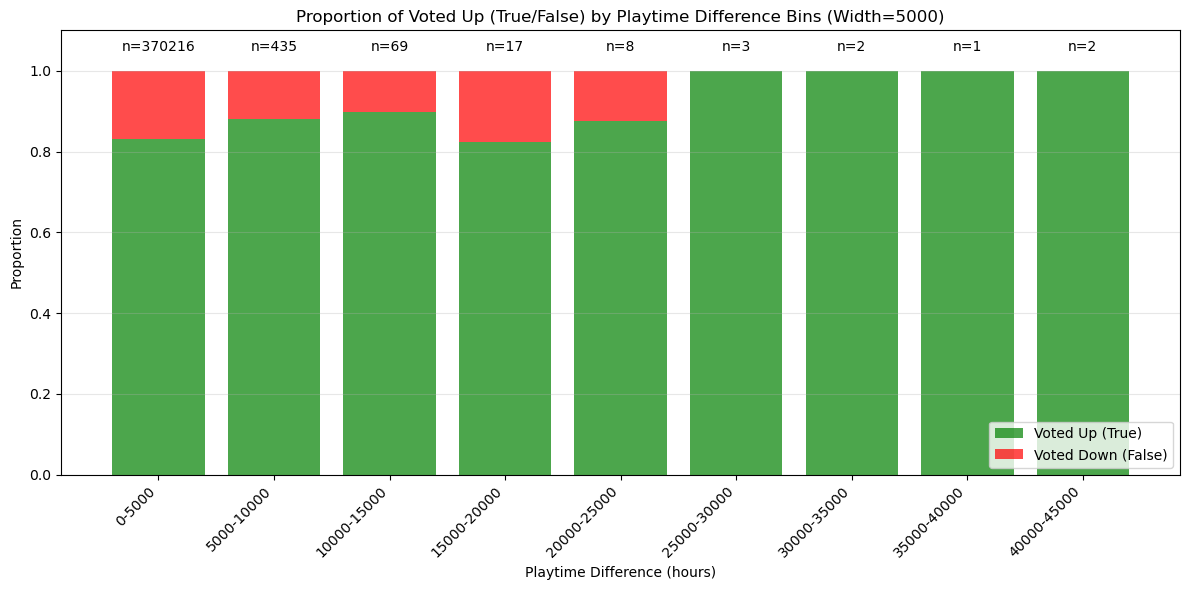

In [39]:
pdf = playtime_difference_vs_voted_up.sample(0.01, seed=420).toPandas()

bin_width = 5000

min_val = pdf['playtime_difference'].min()
max_val = pdf['playtime_difference'].max()

bin_edges = np.arange(
    np.floor(min_val / bin_width) * bin_width,  
    np.ceil(max_val / bin_width) * bin_width + bin_width,  
    bin_width
)

pdf['bin'] = pd.cut(pdf['playtime_difference'], bins=bin_edges, include_lowest=True)
bin_stats = pdf.groupby('bin')['voted_up'].value_counts(normalize=True).unstack().fillna(0)

if True not in bin_stats.columns:
    bin_stats[True] = 0
if False not in bin_stats.columns:
    bin_stats[False] = 0

fig, ax = plt.subplots(figsize=(12, 6))

bin_centers = [(edge1 + edge2) / 2 for edge1, edge2 in zip(bin_edges[:-1], bin_edges[1:])]

ax.bar(bin_centers, bin_stats[True], width=bin_width * 0.8, 
       label='Voted Up (True)', alpha=0.7, color='green')
ax.bar(bin_centers, bin_stats[False], width=bin_width * 0.8, 
       bottom=bin_stats[True], label='Voted Down (False)', alpha=0.7, color='red')

for i, center in enumerate(bin_centers):
    if i < len(bin_stats.index):  
        count = pdf['bin'].value_counts().get(bin_stats.index[i], 0)
        plt.text(center, 1.05, f'n={count}', ha='center')

ax.set_xlabel('Playtime Difference (hours)')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Voted Up (True/False) by Playtime Difference Bins (Width=5000)')
ax.set_ylim(0, 1.1)  

ax.grid(axis='y', alpha=0.3)

plt.xticks(bin_centers, [f'{edge:.0f}-{bin_edges[i+1]:.0f}' for i, edge in enumerate(bin_edges[:-1])], 
           rotation=45, ha='right')

ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [40]:
# Review Length vs Author's Vote
review_length_vs_voted_up = df_fully_cleaned.select(length("review").alias("review_length"), "voted_up")

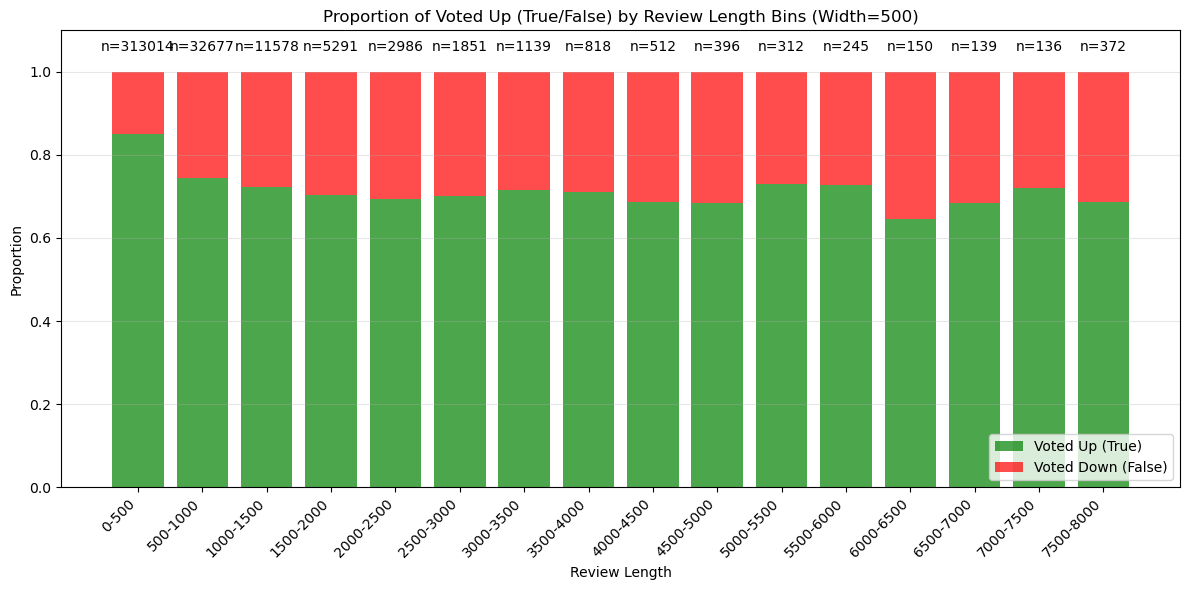

In [41]:
pdf = review_length_vs_voted_up.sample(0.01, seed=42).toPandas()

bin_width = 500

min_val = pdf['review_length'].min()
max_val = pdf['review_length'].max()

bin_edges = np.arange(
    np.floor(min_val / bin_width) * bin_width, 
    np.ceil(max_val / bin_width) * bin_width + bin_width,  
    bin_width
)

pdf['bin'] = pd.cut(pdf['review_length'], bins=bin_edges, include_lowest=True)
bin_stats = pdf.groupby('bin')['voted_up'].value_counts(normalize=True).unstack().fillna(0)

if True not in bin_stats.columns:
    bin_stats[True] = 0
if False not in bin_stats.columns:
    bin_stats[False] = 0

fig, ax = plt.subplots(figsize=(12, 6))

bin_centers = [(edge1 + edge2) / 2 for edge1, edge2 in zip(bin_edges[:-1], bin_edges[1:])]

ax.bar(bin_centers, bin_stats[True], width=bin_width * 0.8, 
       label='Voted Up (True)', alpha=0.7, color='green')
ax.bar(bin_centers, bin_stats[False], width=bin_width * 0.8, 
       bottom=bin_stats[True], label='Voted Down (False)', alpha=0.7, color='red')

for i, center in enumerate(bin_centers):
    if i < len(bin_stats.index):  
        count = pdf['bin'].value_counts().get(bin_stats.index[i], 0)
        plt.text(center, 1.05, f'n={count}', ha='center')

ax.set_xlabel('Review Length')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Voted Up (True/False) by Review Length Bins (Width=500)')
ax.set_ylim(0, 1.1)  

ax.grid(axis='y', alpha=0.3)

plt.xticks(bin_centers, [f'{edge:.0f}-{bin_edges[i+1]:.0f}' for i, edge in enumerate(bin_edges[:-1])], 
           rotation=45, ha='right')

ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

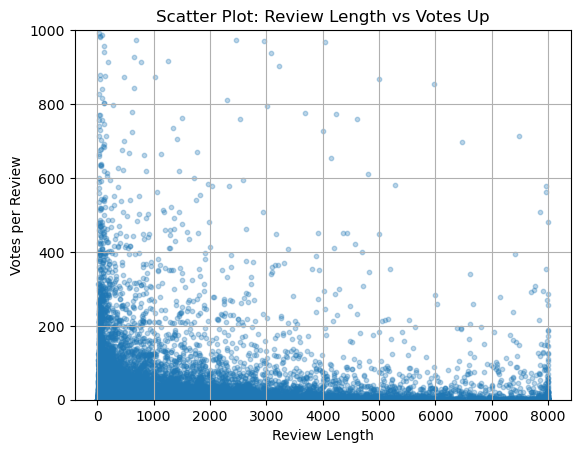

In [42]:
# Review Length vs Community Votes
review_length_votes_up_df = df_fully_cleaned.select(length("review").alias("review_length"), "votes_up").sample(False, 0.01, seed=42)

pandas_df = review_length_votes_up_df.toPandas()

fig, ax = plt.subplots()

ax.scatter(pandas_df["review_length"], pandas_df["votes_up"], alpha=0.3, s=10)
ax.set_ybound(0, 1000)
plt.xlabel("Review Length")
plt.ylabel("Votes per Review")
plt.title("Scatter Plot: Review Length vs Votes Up")
plt.grid(True)
plt.show()

Index([False, True], dtype='bool', name='voted_up')


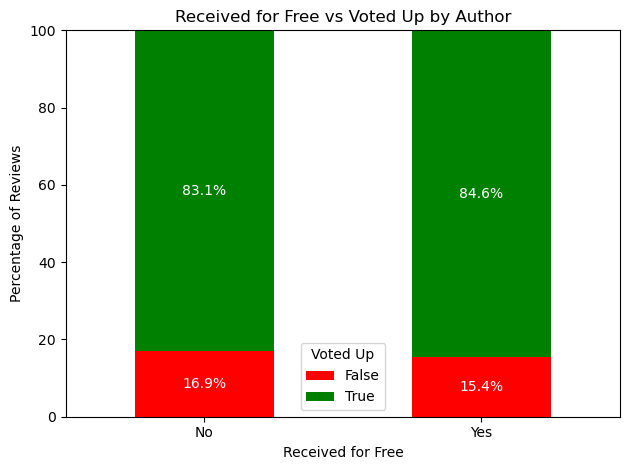

In [43]:
# Received for Free vs Voted Up by Author
free_vs_vote = df_fully_cleaned.groupBy("received_for_free", "voted_up").count()
pandas_df = free_vs_vote.toPandas()

pivot = pandas_df.pivot(index="received_for_free", columns="voted_up", values="count").fillna(0)

print(pivot.columns)

percentages = pivot.div(pivot.sum(axis=1), axis=0) * 100

colors = {0: "red", 1: "green"}
plot_colors = [colors.get(col, "gray") for col in pivot.columns]
ax = percentages.plot(kind="bar", stacked=True, color=plot_colors)

for i, row in percentages.iterrows():
    bottom = 0
    for col in percentages.columns:
        height = row[col]
        ax.text(i, bottom + height / 2, f"{height:.1f}%", ha='center', va='center', color='white', fontsize=10)
        bottom += height

plt.title("Received for Free vs Voted Up by Author")
plt.xlabel("Received for Free")
plt.ylabel("Percentage of Reviews")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"], rotation=0)
plt.ylim(0, 100)
legend_labels = ["Downvoted", "Upvoted"] if 0 in pivot.columns else pivot.columns
plt.legend(title="Voted Up", labels=legend_labels)
plt.tight_layout()
plt.show()

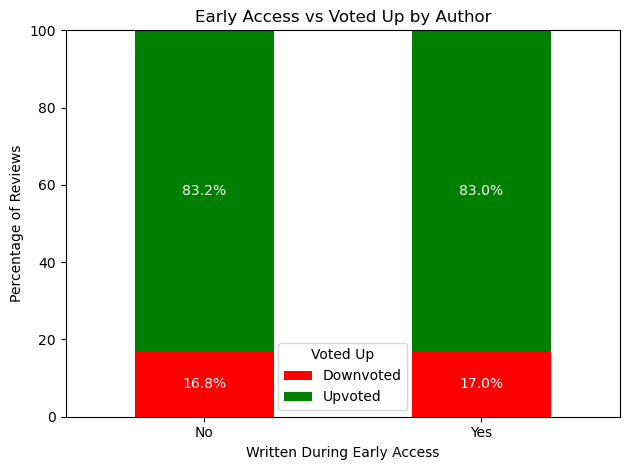

In [44]:
# Early Access vs Voted up by Author
early_vs_vote = df_fully_cleaned.groupBy("written_during_early_access", "voted_up").count()
pandas_df = early_vs_vote.toPandas()

pivot = pandas_df.pivot(index="written_during_early_access", columns="voted_up", values="count").fillna(0)
percentages = pivot.div(pivot.sum(axis=1), axis=0) * 100

colors = {0: "red", 1: "green"}
plot_colors = [colors.get(col, "gray") for col in pivot.columns]
ax = percentages.plot(kind="bar", stacked=True, color=plot_colors)

for i, row in percentages.iterrows():
    bottom = 0
    for col in percentages.columns:
        height = row[col]
        ax.text(i, bottom + height / 2, f"{height:.1f}%", ha='center', va='center', color='white', fontsize=10)
        bottom += height

plt.title("Early Access vs Voted Up by Author")
plt.xlabel("Written During Early Access")
plt.ylabel("Percentage of Reviews")
plt.xticks(ticks=[0, 1], labels=["No", "Yes"], rotation=0)
plt.ylim(0, 100)
plt.legend(title="Voted Up", labels=["Downvoted", "Upvoted"])
plt.tight_layout()
plt.show()

In [46]:
# Overall Correlation Between Each Feature
print(f"Total rows: {df_fully_cleaned.count():,}")
df_fully_cleaned.printSchema()

Total rows: 37,161,679
root
 |-- game: string (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- voted_up: boolean (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- received_for_free: boolean (nullable = true)
 |-- written_during_early_access: boolean (nullable = true)
 |-- at_review_hours: long (nullable = true)
 |-- forever_hours: long (nullable = true)



In [47]:
cols_to_corr = [
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_at_review",
    "votes_up",
    "at_review_hours",
    "forever_hours",
    "voted_up",
    "received_for_free",
    "written_during_early_access"
]

In [50]:

casted_df = df_fully_cleaned
for b in ["voted_up", "received_for_free", "written_during_early_access"]:
    casted_df = casted_df.withColumn(b, col(b).cast("int"))


any_corr = casted_df.select(*cols_to_corr).sample(False, 0.01, seed=42).toPandas()


In [51]:
print("voted_up" in any_corr.columns and any_corr["voted_up"].dtype in ["int64", "float64"])


False


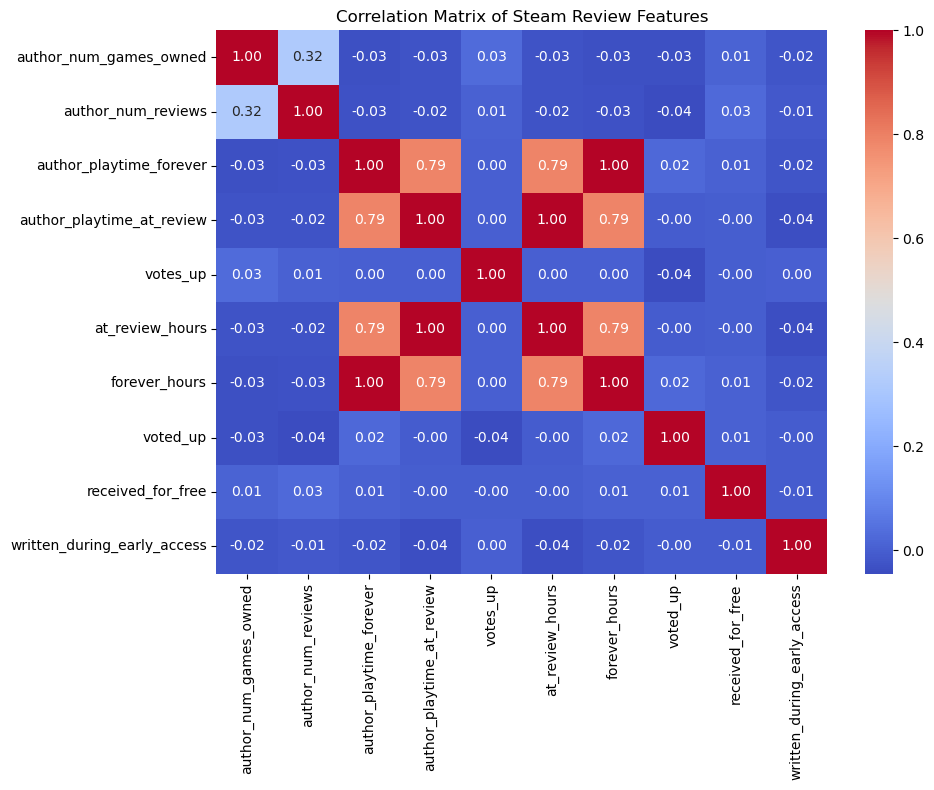

In [52]:
corr_matrix = any_corr.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Steam Review Features")
plt.tight_layout()
plt.show()


In [53]:
pairs = corr_matrix.unstack().sort_values(ascending=False)
top_corrs = pairs[(pairs < 1.0) & (pairs > 0.3)].drop_duplicates()
print(top_corrs)


author_playtime_forever    forever_hours                1.000000
author_playtime_at_review  at_review_hours              1.000000
author_playtime_forever    author_playtime_at_review    0.788451
forever_hours              author_playtime_at_review    0.788451
at_review_hours            author_playtime_forever      0.788449
forever_hours              at_review_hours              0.788448
author_num_reviews         author_num_games_owned       0.321993
dtype: float64


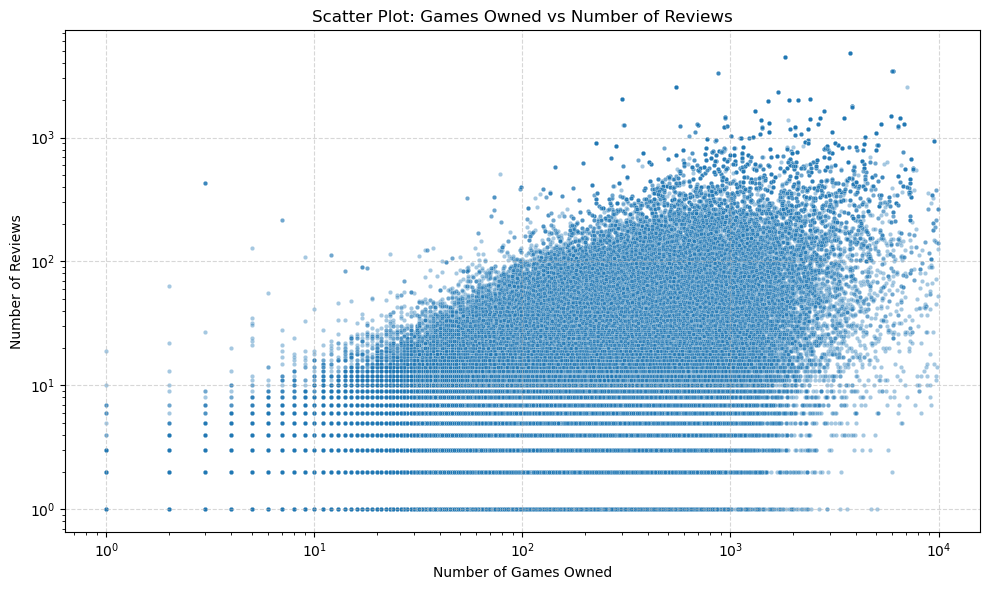

In [54]:
# Games Owned vs Reviews Written
numReviews_v_gamesOwned = df_fully_cleaned.select("author_num_games_owned", "author_num_reviews").sample(False, 0.01, seed=42).toPandas()
filtered = numReviews_v_gamesOwned [
    (numReviews_v_gamesOwned ["author_num_reviews"] < 5000) & 
    (numReviews_v_gamesOwned ["author_num_games_owned"] < 10000)
]


plt.figure(figsize=(10, 6))
plt.scatter(
    filtered["author_num_games_owned"],
    filtered["author_num_reviews"],
    alpha=0.4,
    s=10,
    edgecolors='w',
    linewidth=0.3
)
plt.title("Scatter Plot: Games Owned vs Number of Reviews")
plt.xlabel("Number of Games Owned")
plt.ylabel("Number of Reviews")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## TF-IDF Preprocessing

In [62]:
# Tokenization using RegexTokenizer
regex_tokenizer = RegexTokenizer(inputCol="review", outputCol="tokens", pattern="\\W")
tfidf_df = regex_tokenizer.transform(df_sentiment)

In [63]:
# Stop word removal
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
tfidf_df = remover.transform(tfidf_df)

In [64]:
# Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))
tfidf_df = tfidf_df.withColumn("lemmas", lemmatize_udf(col("filtered_tokens")))

In [65]:
tfidf_df.columns

['review', 'voted_up', 'tokens', 'filtered_tokens', 'lemmas']

In [67]:
# Wrote TFIDF as parquet
# tfidf_df.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/parquet_tfidf_input_final")

In [ ]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_tfidf_input_final"

df_tfidf= sc.read.parquet(path)

In [69]:
df_tfidf.show(10, truncate = 50)

+--------------------------------------------------+--------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                            review|voted_up|                                            tokens|                                   filtered_tokens|                                            lemmas|
+--------------------------------------------------+--------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|great game for early access. very few bugs (non...|    true|[great, game, for, early, access, very, few, bu...|[great, game, early, access, bugs, none, game, ...|[great, game, early, access, bug, none, game, b...|
|were loving the game so far i just hope they up...|    true|[were, loving, the, game, so, far, i, just, hop...|[loving, game, far, hope, up

In [70]:
# Count number of reviews marked as voted down
voted_down_count = df_tfidf.filter(col("voted_up") == False).count()
print(f"Number of voted down reviews: {voted_down_count:,}")

# Count number of reviews marked as voted up
voted_up_count = df_tfidf.filter(col("voted_up") == True).count()
print(f"Number of voted up reviews: {voted_up_count:,}")


Number of voted down reviews: 6,256,826
Number of voted up reviews: 30,904,853


## Word2Vec Preprocessing

In [3]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_sentiment"

df_sentiment = sc.read.parquet(path)

In [4]:
# Current columns used for sentiment
df_sentiment.columns

['review', 'voted_up']

In [5]:
df_sentiment.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[review: string, voted_up: boolean]

In [7]:
df_sentiment.count()

37161679

In [8]:
df_sentiment.dtypes

[('review', 'string'), ('voted_up', 'boolean')]

In [11]:
# Word2Vec Preprocessing(Word Embedding)
from pyspark.ml.feature import Tokenizer

df_word2vec = df_sentiment.select("review", "voted_up")
word2vec_tokenizer = Tokenizer(inputCol="review", outputCol="tokens")
df_word2vec = word2vec_tokenizer.transform(df_word2vec)
df_word2vec = df_word2vec.withColumn('voted_up', col('voted_up').cast('int'))

In [13]:
#df_word2vec.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/parquet_word2vec_final")

In [21]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_word2vec_final"

df_word2vec= sc.read.parquet(path)

In [22]:
df_word2vec.show(10, truncate = 50)

+--------------------------------------------------+--------+--------------------------------------------------+
|                                            review|voted_up|                                            tokens|
+--------------------------------------------------+--------+--------------------------------------------------+
|a fun game, but the inconsistency of movement a...|       1|[a, fun, game,, but, the, inconsistency, of, mo...|
|this game is very good if you can find a server...|       1|[this, game, is, very, good, if, you, can, find...|
|gay game, only gay tryhard eastern european 87%...|       0|[gay, game,, only, gay, tryhard, eastern, europ...|
|took 200 hours for me to realise what a piece o...|       0|[took, 200, hours, for, me, to, realise, what, ...|
|i dont know what else to say besides fuck this ...|       1|[i, dont, know, what, else, to, say, besides, f...|
|it'll hold you till chivalry 2 comes out on ste...|       1|[it'll, hold, you, till, chivalry, 

# Milestone 3: TF-IDF Model Creation

## Setup

In [26]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_tfidf_input_final"

df_tfidf= sc.read.parquet(path)

In [27]:
df_tfidf.show(10, truncate = 50)

+--------------------------------------------------+--------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                            review|voted_up|                                            tokens|                                   filtered_tokens|                                            lemmas|
+--------------------------------------------------+--------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|great game for early access. very few bugs (non...|    true|[great, game, for, early, access, very, few, bu...|[great, game, early, access, bugs, none, game, ...|[great, game, early, access, bug, none, game, b...|
|were loving the game so far i just hope they up...|    true|[were, loving, the, game, so, far, i, just, hop...|[loving, game, far, hope, up

In [28]:
df_tfidf = df_tfidf.withColumn("voted_up", col("voted_up").cast("int"))

In [29]:
# Keep only the lemmatized tokens and the review polarity
df_tfidf = df_tfidf[["lemmas", "voted_up"]]

In [30]:
# Separate the classes
positive_tfidf = df_tfidf.filter(df_tfidf.voted_up == 1)
negative_tfidf = df_tfidf.filter(df_tfidf.voted_up == 0)

# Sample positive class down to match negative count
pos_sampled_tfidf = positive_tfidf.sample(False, float(6256826) / positive_tfidf.count(), seed=42)

# Union the balanced dataset
balanced_tfidf = pos_sampled_tfidf.union(negative_tfidf)

In [31]:
balanced_tfidf.groupBy('voted_up').count().show()

+--------+-------+
|voted_up|  count|
+--------+-------+
|       1|6258322|
|       0|6256826|
+--------+-------+



In [32]:
#Wrote the 14M downsampled dataset to storage
#balanced_tfidf.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/tfidf_14M")

In [33]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/tfidf_14M"

df_tfidf= sc.read.parquet(path)

In [34]:
df_tfidf.groupBy('voted_up').count().show()

+--------+-------+
|voted_up|  count|
+--------+-------+
|       0|6256826|
|       1|6258322|
+--------+-------+



In [35]:
from pyspark.sql.functions import rand
# Take ~1M total rows
positive_tfidf_14M = df_tfidf.filter(df_tfidf.voted_up == 1)
negative_tfidf_14M = df_tfidf.filter(df_tfidf.voted_up == 0)
tuning_tfidf_pos = positive_tfidf_14M.orderBy(rand()).limit(500000)
tuning_tfidf_neg = negative_tfidf_14M.orderBy(rand()).limit(500000)
hyper_tfidf_df = tuning_tfidf_pos.union(tuning_tfidf_neg)

In [36]:
hyper_tfidf_df.groupBy('voted_up').count().show()

+--------+------+
|voted_up| count|
+--------+------+
|       1|500000|
|       0|500000|
+--------+------+



In [37]:
#Wrote the 1M downsampled tuning dataset to storage
#hyper_tfidf_df.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/tfidf_1M_tuning")

## Initial TF-IDF

### Dataset Selection

In [ ]:
# Original dataset
# path = "/expanse/lustre/scratch/troman1/temp_project/parquet_tfidf_input_final"

# Balanced 14M dataset
path = "/expanse/lustre/scratch/troman1/temp_project/tfidf_14M"

df_tfidf= sc.read.parquet(path)

Training with numFeatures = 1000...


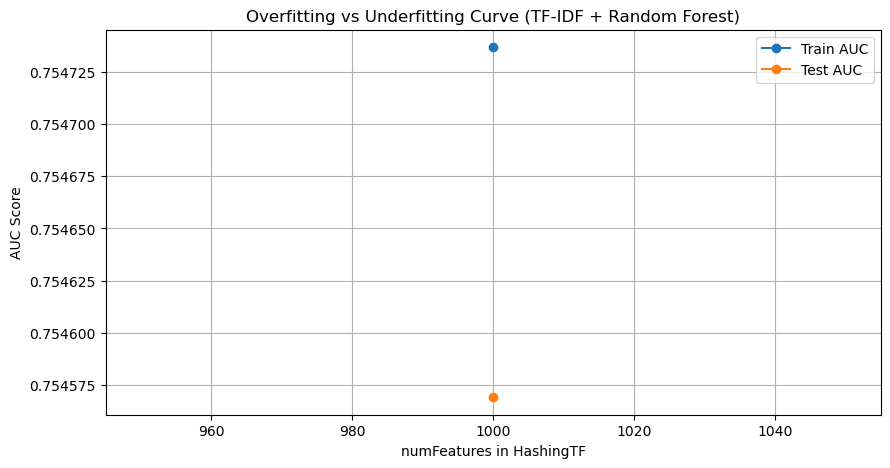

In [39]:
#Experimental and testing for graphing
# Split data once
train_df, test_df = df_tfidf.randomSplit([0.8, 0.2], seed=42)

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")

# Track results
feature_sizes = [1000]
train_accuracies = []
test_accuracies = []

for value in feature_sizes:
    print(f"Training with numFeatures = {value}...")

    hashing_tf = HashingTF(inputCol="lemmas", outputCol="raw_features", numFeatures=value)
    tfidf = IDF(inputCol="raw_features", outputCol="features")
    rf = RandomForestClassifier(featuresCol="features", labelCol="voted_up", numTrees=50)

    tfidf_pipeline = Pipeline(stages=[hashing_tf, tfidf, rf])

    tfidf_model = tfidf_pipeline.fit(train_df)

    train_predictions = tfidf_model.transform(train_df)
    test_predictions = tfidf_model.transform(test_df)

    train_accuracy = evaluator.evaluate(train_predictions)
    test_accuracy = evaluator.evaluate(test_predictions)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(feature_sizes, train_accuracies, label="Train AUC", marker='o')
plt.plot(feature_sizes, test_accuracies, label="Test AUC", marker='o')
plt.xlabel("numFeatures in HashingTF")
plt.ylabel("AUC Score")
plt.title("Overfitting vs Underfitting Curve (TF-IDF + Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
hashing_tf = HashingTF(inputCol = 'lemmas', outputCol ='raw_features', numFeatures = 1000)
tfidf = IDF(inputCol = 'raw_features', outputCol = 'features')

In [41]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'voted_up', numTrees = 50)
evaluator = BinaryClassificationEvaluator(labelCol = 'voted_up', rawPredictionCol = 'rawPrediction')

In [42]:
tfidf_pipeline = Pipeline(stages = [hashing_tf, tfidf, rf])
train_tfidf, test_tfidf = df_tfidf.randomSplit([.8, .2], seed = 42)
tfidf_model = tfidf_pipeline.fit(train_tfidf)

In [43]:
tfidf_train_predictions = tfidf_model.transform(train_tfidf)

tfidf_auc = evaluator.evaluate(tfidf_train_predictions)
print(f"TFIDF + Random Forest Training AUC: {tfidf_auc:.4f}")

TFIDF + Random Forest Training AUC: 0.7546


In [44]:
tfidf_test_predictions = tfidf_model.transform(test_tfidf)

tfidf_auc = evaluator.evaluate(tfidf_test_predictions)
print(f"TFIDF + Random Forest Test AUC: {tfidf_auc:.4f}")

TFIDF + Random Forest Test AUC: 0.7547


## Tuning numFeatures


Training with numFeatures = 50...
Train AUC: 0.6577 | Test AUC: 0.6591

Training with numFeatures = 1000...
Train AUC: 0.7546 | Test AUC: 0.7546

Training with numFeatures = 2000...
Train AUC: 0.7589 | Test AUC: 0.7587

Training with numFeatures = 5000...
Train AUC: 0.7716 | Test AUC: 0.7715

Training with numFeatures = 10000...
Train AUC: 0.7772 | Test AUC: 0.7771


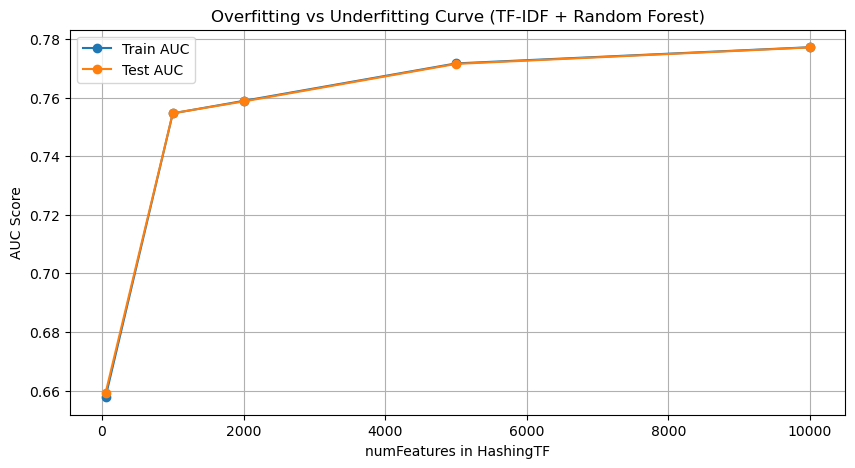

In [45]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Split once
train_tfidf, test_tfidf = df_tfidf.randomSplit([0.8, 0.2], seed=42)

# Set up evaluator
evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")

# Track results
feature_sizes = [50, 1000, 2000, 5000, 10000]
train_aucs = []
test_aucs = []

# Loop through different numFeatures
for size in feature_sizes:
    print(f"\nTraining with numFeatures = {size}...")
    
    hashing_tf = HashingTF(inputCol="lemmas", outputCol="raw_features", numFeatures=size)
    tfidf = IDF(inputCol="raw_features", outputCol="features")
    rf = RandomForestClassifier(featuresCol="features", labelCol="voted_up", numTrees=50)

    pipeline = Pipeline(stages=[hashing_tf, tfidf, rf])
    model = pipeline.fit(train_tfidf)

    train_preds = model.transform(train_tfidf)
    test_preds = model.transform(test_tfidf)

    train_auc = evaluator.evaluate(train_preds)
    test_auc = evaluator.evaluate(test_preds)

    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

    print(f"Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f}")

# Plotting the fitting graph
plt.figure(figsize=(10, 5))
plt.plot(feature_sizes, train_aucs, label="Train AUC", marker='o')
plt.plot(feature_sizes, test_aucs, label="Test AUC", marker='o')
plt.xlabel("numFeatures in HashingTF")
plt.ylabel("AUC Score")
plt.title("Overfitting vs Underfitting Curve (TF-IDF + Random Forest)")
plt.legend()
plt.grid(True)
plt.show()


## Tuning numTrees

In [46]:
# Downsample to manageable numbers
pos_df = df_tfidf[df_tfidf["voted_up"]==1].sample(0.2, seed=42)
neg_df = df_tfidf[df_tfidf["voted_up"]==0].sample(0.2, seed=42)

downsampled_tfidf = pos_df.union(neg_df)


Training with numTrees = 50...
Train AUC: 0.7705 | Test AUC: 0.7708
Train Accuracy: 0.6852 | Test Accuracy: 0.6856

Training with numTrees = 100...
Train AUC: 0.7771 | Test AUC: 0.7776
Train Accuracy: 0.6898 | Test Accuracy: 0.6908

Training with numTrees = 150...
Train AUC: 0.7780 | Test AUC: 0.7787
Train Accuracy: 0.6885 | Test Accuracy: 0.6891

Training with numTrees = 250...
Train AUC: 0.7834 | Test AUC: 0.7838
Train Accuracy: 0.6931 | Test Accuracy: 0.6937

Training with numTrees = 400...
Train AUC: 0.7882 | Test AUC: 0.7887
Train Accuracy: 0.6963 | Test Accuracy: 0.6974


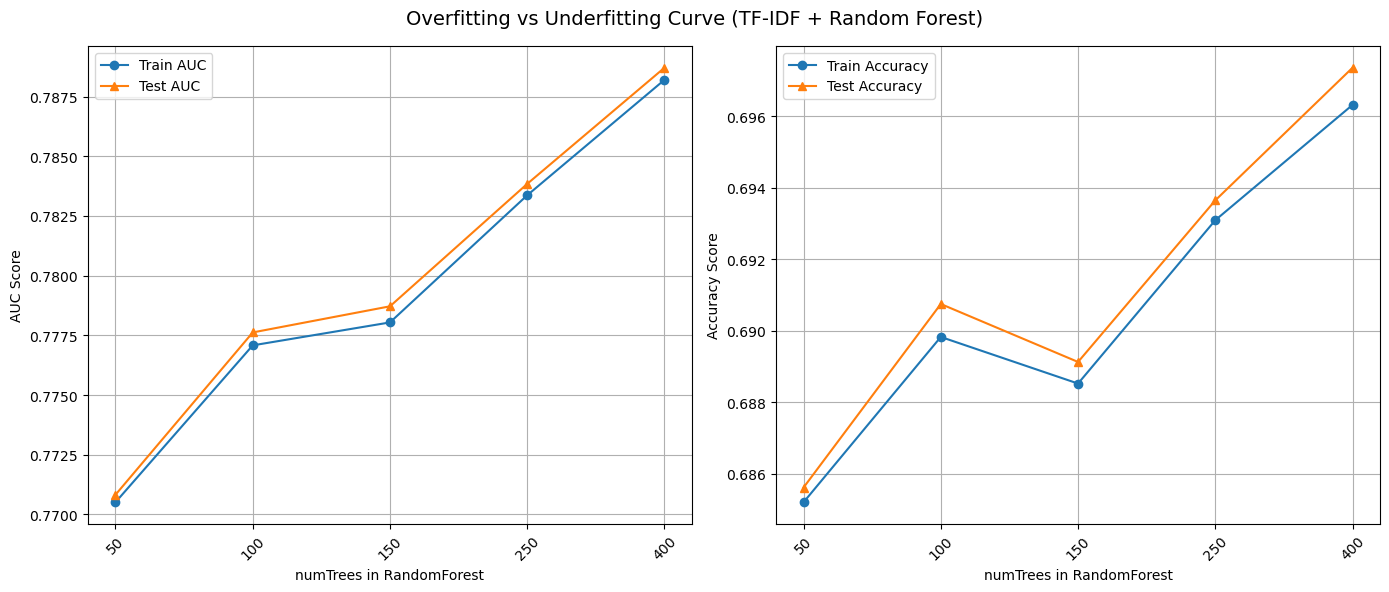

In [52]:
# Using numFeatures = 5000

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split once
train_tfidf, test_tfidf = downsampled_tfidf.randomSplit([0.8, 0.2], seed=42)

# Set up evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="voted_up", predictionCol="prediction")

numTrees = [50, 100, 150, 250, 400]

train_aucs = []
test_aucs = []
train_accs = []
test_accs = []
# train_aucs = [0.7459, 0.7711]
# test_aucs = [0.7460, 0.7713]

# Loop through different numFeatures
for num in numTrees:
    print(f"\nTraining with numTrees = {num}...")
    
    hashing_tf = HashingTF(inputCol="lemmas", outputCol="raw_features", numFeatures=5000)
    tfidf = IDF(inputCol="raw_features", outputCol="features")
    rf = RandomForestClassifier(featuresCol="features", labelCol="voted_up", numTrees=num)

    pipeline = Pipeline(stages=[hashing_tf, tfidf, rf])
    model = pipeline.fit(train_tfidf)

    train_preds = model.transform(train_tfidf)
    test_preds = model.transform(test_tfidf)

    train_auc = binary_evaluator.evaluate(train_preds)
    test_auc = binary_evaluator.evaluate(test_preds)
    train_acc = multi_evaluator.evaluate(train_preds, {multi_evaluator.metricName: "accuracy"})
    test_acc = multi_evaluator.evaluate(test_preds, {multi_evaluator.metricName: "accuracy"})

    train_aucs.append(train_auc)
    test_aucs.append(test_auc)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

# Plotting the fitting graph
# plt.figure(figsize=(10, 5))
# plt.plot(feature_sizes, train_aucs, label="Train AUC", marker='o')
# plt.plot(feature_sizes, test_aucs, label="Test AUC", marker='^')

# plt.xlabel("numTrees in RandomForest")
# plt.ylabel("AUC Score")
# plt.title("Overfitting vs Underfitting Curve (TF-IDF + Random Forest)")
# plt.legend()
# plt.grid(True)
# plt.show()

x_labels = [str(n) for n in numTrees]
x_pos = list(range(len(numTrees)))

plt.figure(figsize=(14, 6))
plt.suptitle("Overfitting vs Underfitting Curve (TF-IDF + Random Forest)", fontsize=14)

plt.subplot(1, 2, 1)
plt.plot(x_pos, train_aucs, label="Train AUC", marker='o')
plt.plot(x_pos, test_aucs, label="Test AUC", marker='^')
plt.xlabel("numTrees in RandomForest")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(x_pos, x_labels, rotation=45)

plt.subplot(1, 2, 2)
plt.plot(x_pos, train_accs, label="Train Accuracy", marker='o')
plt.plot(x_pos, test_accs, label="Test Accuracy", marker='^')
plt.xlabel("numTrees in RandomForest")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True)
plt.xticks(x_pos, x_labels, rotation=45)

plt.tight_layout()
plt.show()


## Tuning maxDepth

In [53]:
# Downsample to manageable numbers
pos_df = df_tfidf[df_tfidf["voted_up"]==1].sample(0.2, seed=42)
neg_df = df_tfidf[df_tfidf["voted_up"]==0].sample(0.2, seed=42)

downsampled_tfidf = pos_df.union(neg_df)


Training with maxDepth = 1...
Train AUC: 0.7595 | Test AUC: 0.7600
Train Accuracy: 0.6694 | Test Accuracy: 0.6699

Training with maxDepth = 3...
Train AUC: 0.7751 | Test AUC: 0.7757
Train Accuracy: 0.6841 | Test Accuracy: 0.6849

Training with maxDepth = 5...
Train AUC: 0.7882 | Test AUC: 0.7887
Train Accuracy: 0.6963 | Test Accuracy: 0.6974

Training with maxDepth = 7...
Train AUC: 0.7991 | Test AUC: 0.7996
Train Accuracy: 0.7074 | Test Accuracy: 0.7079


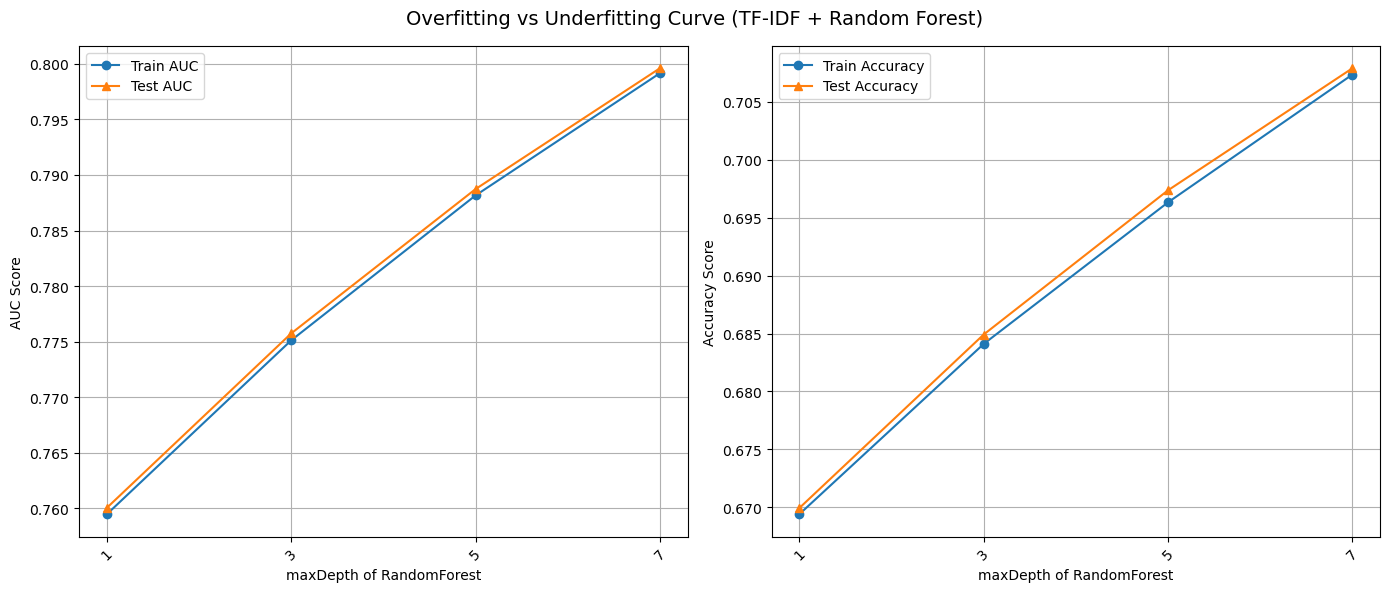

In [54]:
# Using numFeatures = 5000 and numTrees = 400

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Split once
train_tfidf, test_tfidf = downsampled_tfidf.randomSplit([0.8, 0.2], seed=42)

# Set up evaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="voted_up", predictionCol="prediction")

maxDepths = [1, 3, 5, 7]

train_aucs = []
test_aucs = []
train_accs = []
test_accs = []

# Loop through different numFeatures
for depth in maxDepths:
    print(f"\nTraining with maxDepth = {depth}...")
    
    hashing_tf = HashingTF(inputCol="lemmas", outputCol="raw_features", numFeatures=5000)
    tfidf = IDF(inputCol="raw_features", outputCol="features")
    rf = RandomForestClassifier(featuresCol="features", labelCol="voted_up", numTrees=400, maxDepth=depth)

    pipeline = Pipeline(stages=[hashing_tf, tfidf, rf])
    model = pipeline.fit(train_tfidf)

    train_preds = model.transform(train_tfidf)
    test_preds = model.transform(test_tfidf)

    train_auc = binary_evaluator.evaluate(train_preds)
    test_auc = binary_evaluator.evaluate(test_preds)
    train_acc = multi_evaluator.evaluate(train_preds, {multi_evaluator.metricName: "accuracy"})
    test_acc = multi_evaluator.evaluate(test_preds, {multi_evaluator.metricName: "accuracy"})

    train_aucs.append(train_auc)
    test_aucs.append(test_auc)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f}")
    print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

x_labels = [str(d) for d in maxDepths]
x_pos = list(range(len(maxDepths)))

plt.figure(figsize=(14, 6))
plt.suptitle("Overfitting vs Underfitting Curve (TF-IDF + Random Forest)", fontsize=14)

plt.subplot(1, 2, 1)
plt.plot(x_pos, train_aucs, label="Train AUC", marker='o')
plt.plot(x_pos, test_aucs, label="Test AUC", marker='^')
plt.xlabel("maxDepth of RandomForest")
plt.ylabel("AUC Score")
plt.legend()
plt.grid(True)
plt.xticks(x_pos, x_labels, rotation=45)

plt.subplot(1, 2, 2)
plt.plot(x_pos, train_accs, label="Train Accuracy", marker='o')
plt.plot(x_pos, test_accs, label="Test Accuracy", marker='^')
plt.xlabel("maxDepth of RandomForest")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True)
plt.xticks(x_pos, x_labels, rotation=45)

plt.tight_layout()
plt.show()



## Ground Truth Tables

In [27]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a row ID to both DataFrames
train_tfidf_with_id = train_tfidf.withColumn("id", monotonically_increasing_id())
train_preds_with_id = train_preds.withColumn("id", monotonically_increasing_id())


# Join the DataFrames on the ID column
train_ground_truth = train_tfidf_with_id.join(
    train_preds_with_id.select("id", "prediction"), 
    on="id", 
    how="inner"
).drop("id")

print("Training Set Ground Truth")
train_ground_truth.show(5)

Training Set Ground Truth
+--------------------+--------+----------+
|              lemmas|voted_up|prediction|
+--------------------+--------+----------+
|[7, 10, vanilla, ...|     1.0|       1.0|
|[9, 10, gordon, r...|     1.0|       1.0|
|[achievement, spa...|     1.0|       1.0|
|[add, cart, butto...|     1.0|       1.0|
|[always, wondered...|     1.0|       1.0|
+--------------------+--------+----------+
only showing top 5 rows



In [28]:
test_tfidf_with_id = test_tfidf.withColumn("id", monotonically_increasing_id())
test_preds_with_id = test_preds.withColumn("id", monotonically_increasing_id())

test_ground_truth = test_tfidf_with_id.join(
    test_preds_with_id.select("id", "prediction"), 
    on="id", 
    how="inner"
).drop("id")  # Drop the ID column after joining if not needed

print("Test Set Ground Truth")
test_ground_truth.show(5)

Test Set Ground Truth
+--------------------+--------+----------+
|              lemmas|voted_up|prediction|
+--------------------+--------+----------+
|[best, game, ever...|     1.0|       1.0|
|[best, game, need...|     1.0|       1.0|
|[cant, wait, skyr...|     1.0|       1.0|
|[collar, start, b...|     1.0|       1.0|
|[elder, scroll, f...|     1.0|       1.0|
+--------------------+--------+----------+
only showing top 5 rows



# Milestone 4: Word2Vec Model Creation

In [4]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/parquet_word2vec_final"

df_word2vec= sc.read.parquet(path)

In [5]:
df_word2vec.show(10, truncate=50)

+--------------------------------------------------+--------+--------------------------------------------------+
|                                            review|voted_up|                                            tokens|
+--------------------------------------------------+--------+--------------------------------------------------+
|a fun game, but the inconsistency of movement a...|       1|[a, fun, game,, but, the, inconsistency, of, mo...|
|this game is very good if you can find a server...|       1|[this, game, is, very, good, if, you, can, find...|
|gay game, only gay tryhard eastern european 87%...|       0|[gay, game,, only, gay, tryhard, eastern, europ...|
|took 200 hours for me to realise what a piece o...|       0|[took, 200, hours, for, me, to, realise, what, ...|
|i dont know what else to say besides fuck this ...|       1|[i, dont, know, what, else, to, say, besides, f...|
|it'll hold you till chivalry 2 comes out on ste...|       1|[it'll, hold, you, till, chivalry, 

In [4]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Word2Vec

w2v = Word2Vec(
    vectorSize=100, 
    seed=42, 
    inputCol="tokens",
    outputCol="model"
)

In [6]:
df_word2vec.persist(StorageLevel.MEMORY_AND_DISK)
df_word2vec.count()

37161679

In [9]:
df_word2vec.groupBy("voted_up").count().show()


+--------+--------+
|voted_up|   count|
+--------+--------+
|       1|30904853|
|       0| 6256826|
+--------+--------+



In [11]:
# Separate the classes
positive_df = df_word2vec.filter(df_word2vec.voted_up == 1)
negative_df = df_word2vec.filter(df_word2vec.voted_up == 0)

# Sample positive class down to match negative count
pos_sampled = positive_df.sample(False, float(6256826) / positive_df.count(), seed=42)

# Union the balanced dataset
balanced_df = pos_sampled.union(negative_df)

In [13]:
balanced_df.groupBy("voted_up").count().show()

+--------+-------+
|voted_up|  count|
+--------+-------+
|       1|6257903|
|       0|6256826|
+--------+-------+



In [19]:
#Wrote the 14M downsampled dataset to storage
#balanced_df.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/word2vec_14M")

In [22]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/word2vec_14M"

df_word2vec= sc.read.parquet(path)

In [23]:
df_word2vec.groupBy("voted_up").count().show()

+--------+-------+
|voted_up|  count|
+--------+-------+
|       0|6256826|
|       1|6257903|
+--------+-------+



In [25]:
from pyspark.sql.functions import rand
# Take ~1M total rows
positive_14M = df_word2vec.filter(df_word2vec.voted_up == 1)
negative_14M = df_word2vec.filter(df_word2vec.voted_up == 0)
tuning_pos = positive_14M.orderBy(rand()).limit(500000)
tuning_neg = negative_14M.orderBy(rand()).limit(500000)
hyper_df = tuning_pos.union(tuning_neg)

In [26]:
hyper_df.groupBy("voted_up").count().show()

+--------+------+
|voted_up| count|
+--------+------+
|       1|500000|
|       0|500000|
+--------+------+



In [27]:
#Wrote the 1M downsampled tuning dataset to storage
#hyper_df.write.mode("overwrite").parquet("/expanse/lustre/scratch/troman1/temp_project/word2vec_1M_tuning")

In [28]:
# Read in parquet file
path = "/expanse/lustre/scratch/troman1/temp_project/word2vec_1M_tuning"

hyper_df= sc.read.parquet(path)

In [29]:
hyper_df.groupBy("voted_up").count().show()

+--------+------+
|voted_up| count|
+--------+------+
|       1|500000|
|       0|500000|
+--------+------+



In [ ]:
log_classifier = LogisticRegression(featuresCol="model", labelCol="voted_up")

w2v_pipeline = Pipeline(stages=[w2v, log_classifier])
train_w2v, test_w2v = df_word2vec.randomSplit([.8, .2], seed=42)
w2v_model = w2v_pipeline.fit(train_w2v)
evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")
w2v_train_predictions = w2v_model.transform(train_w2v)

w2v_auc = evaluator.evaluate(w2v_train_predictions)
print(f"Word2Vec + Logistic Regression AUC: {w2v_auc:.4f}")

w2v_test_predictions = w2v_model.transform(test_w2v)

w2v_auc = evaluator.evaluate(w2v_train_predictions)
print(f"Word2Vec + Logistic Regression AUC: {w2v_auc:.4f}")

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="voted_up", rawPredictionCol="rawPrediction")

In [ ]:
w2v_train_predictions = w2v_model.transform(train_w2v)

w2v_auc = evaluator.evaluate(w2v_train_predictions)
print(f"Word2Vec + Logistic Regression AUC: {w2v_auc:.4f}")

In [ ]:
w2v_test_predictions = w2v_model.transform(test_w2v)

w2v_auc = evaluator.evaluate(w2v_train_predictions)
print(f"Word2Vec + Logistic Regression AUC: {w2v_auc:.4f}")